# Classes Generator by Folder

In this notebook we are going to clean the input file and separate the pictures by classes in their respective directory.

I will do this only to test another strategy to create a new neural network in keras.

The purpose of this section is select the image arrays that corresponds to the selected input choosed in the previous section.

In [22]:
import numpy as np
from grabscreen import grab_screen
import cv2
#import tdqm
import os
import pandas as pd
#from tqdm import tqdm
from collections import deque
from models import inception_v3 as googlenet
from models import alexnet2
from random import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
WIDTH = 480
HEIGHT = 270


from IPython.display import clear_output, Image, display
import PIL.Image
from matplotlib import pyplot as plt

def showarray(a, fmt='jpeg'):
    a_n = np.uint8(np.clip(a, 0, 255))
    try :
        f = io.BytesIO()
        PIL.Image.fromarray(a_n).save(f, fmt)
        display(Image(data=f.getvalue()))
    except:
        #a = a[:, :, ::-1] # convert image from RGB (skimage) to BGR (opencv)
        # display image   
        plt.imshow(a)
        plt.show()  

def df_to_numpy_input(df_input,index): 
    # flattening a 2d numpy array
    # into 1d array
    # and remove dtype at the end of numpy array
    lista=df_input.loc[[index]].values.tolist()
    arr=np.array(lista).ravel()
    return arr

def df_to_numpy_image(df_image_clean,index):
    #select the row with index label 'index'
    image_clean=df_image_clean.loc[[index]].T.to_numpy()
    lists =image_clean.tolist()
    # Nested List Comprehension to flatten a given 2-D matrix
    # 2-D List
    matrix = lists
    flatten_matrix = [val.tolist() for sublist in matrix for val in sublist]
    # converting list to array
    arr = np.array(flatten_matrix)
    return arr
def cleaning_data_reduced(train_data , show=False):    
    #Creation and cleaning of the input dataframe
    df = pd.DataFrame()
    for i in range(len(train_data)):
        row=list(train_data[i][1])
        #print(row)
        temp = pd.DataFrame([row])
       # print(temp)
        df = pd.concat([df, temp])
    df=df.reset_index(drop=True)


    # Parameters of the cleaning part
    num_bins = 25
    # We choose the threshold by choosing the RX diffeerent of zero
    threshold= (df[13] != 0).astype(int).sum(axis=0)
    samples_per_bin = threshold
    hist, bins = np.histogram(df[13], num_bins)
    center = (bins[:-1]+ bins[1:]) * 0.5    
    
    
    #Cleaning procedure
    remove_list = []
    for j in range(num_bins):
        list_ = []
        for i in range(len(df[13])):
            serie=df[13].iloc[[i]]
            ls = serie.tolist()
            if ls[0] >= bins[j] and ls[0] <= bins[j+1]:
                list_.append(i)      
        #list_ = shuffle(list_)
        list_ = list_[samples_per_bin:]
        remove_list.extend(list_)
        
    #Implementation of the cleaning    
    df_removed=df.drop(remove_list, axis=0, inplace=False)
    df.drop(df.index[remove_list], inplace=True)
    
    
    
    ## We select only the columns different to zero###
    df=df.loc[:, (df != 0).any()]
    
    ## We remove the NO Key
    del df[8]
    
    print('remaining:', len(df))
    df=df.reset_index(drop=True) # We reset the index ! attention    
    if show == True:
        #Visualization of cleaning
        hist, _ = np.histogram(df[13], (num_bins))
        plt.bar(center, hist, width=0.05)
        plt.plot((np.min(df[13]), np.max(df[13])), (samples_per_bin, samples_per_bin))
    
    #Creation and cleaning of the image dataframe
    
    df_image = pd.DataFrame()
    for i in range(len(train_data)):
        row=list(train_data[i][0]) # For images  Here we lost the (i, 480, 3) shape
        #print(row)    
        temp = pd.DataFrame([row])
       # print(temp)
        df_image = pd.concat([df_image, temp])
    df_image=df_image.reset_index(drop=True)
    df_image_removed=df_image.drop(remove_list, axis=0, inplace=False)
    df_image_clean=df_image_removed.reset_index(drop=True)
    #We verify that the dimensions are the same
    assert len(df) == len(df_image_clean), "The dimensions are not equal, something is wrong "
    
    return df_image_clean, df

Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
#processed image rgb color - no image filters
file_name = "preprocessed_training_data-2.npy"
# full file information
train_data = np.load(file_name,allow_pickle=True)

# Standard Cleaning

remaining: 38


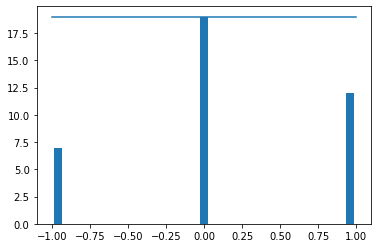

In [14]:
df_image_clean, df = cleaning_data_reduced(train_data,show=True)

In [15]:
df.head()

,12,13
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [16]:
df.describe()

,12,13
count,38.0,38.000000
mean,1.0,0.131579
std,0.0,0.704083
min,1.0,-1.000000
25%,1.0,0.000000
50%,1.0,0.000000
75%,1.0,1.000000
max,1.0,1.000000


Training Samples: 30
Valid Samples: 8


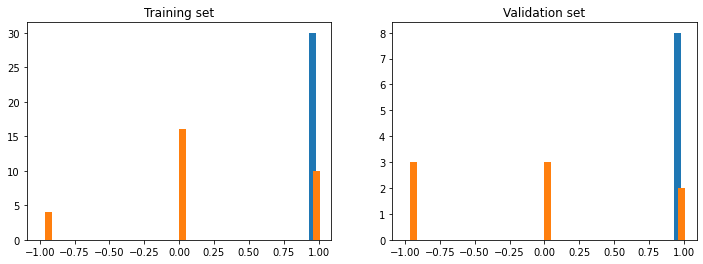

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(df_image_clean, df, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(y_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
num_bins=25
axes[0].hist(y_train, bins=num_bins, width=0.05)
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05)
axes[1].set_title('Validation set')
# Train Image part ( 4 Dimensional)
X_image = np.array([df_to_numpy_image(X_train,i) for i in X_train.index])
X=X_image.reshape(-1,WIDTH,HEIGHT,3)
#Train Input part ( 1 Dimensional )
Y = [df_to_numpy_input(y_train,i) for i in y_train.index]
# Test Image part ( 4 Dimensional)
test_image = np.array([df_to_numpy_image(X_valid,i) for i in X_valid.index])
test_x=test_image.reshape(-1,WIDTH,HEIGHT,3)
## Test Input part( 1 Dimensional )
test_y = [df_to_numpy_input(y_valid,i) for i in y_valid.index]

Let us choose a picture where was used lx

In [18]:
# selecting rows based on condition LX to the left
y_train.loc[y_train[13] < 0]

,12,13
26,1,-1
27,1,-1
24,1,-1
20,1,-1


In [19]:
def show_action_reduced(X_train,y_train,index_to_select):
    dato=np.array([y_train.loc[index_to_select].tolist()])
    columna_name=['W', 'S', 'A', 'D', 'WA', 'WD', 'SA', 'SD','NOKEY','LT', 'RT', 'Lx', 'Ly', 'Rx', 'Ry', 'UP', 'DOWN', 'LEFT', 'RIGHT',
           'START', 'SELECT', 'L3', 'R3', 'LB', 'RB', 'A', 'B', 'X', 'Y']
    columna=[columna_name[x] for x in y_train.columns ]
    #print(columna)
    df_pred = pd.DataFrame(dato,columns=columna)
    df_pred_transposed = df_pred.T 
    print(df_pred_transposed) 
    image_check=df_to_numpy_image(X_train,index_to_select)
    showarray(image_check)

In [20]:
y_train.head()

,12,13
17,1,0
26,1,-1
32,1,1
6,1,0
36,1,1


    0
Ly  1
Rx -1


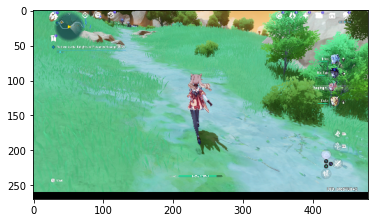

In [21]:
show_action_reduced(X_train,y_train,24)

In [22]:
#from tqdm import tqdm      # a nice pretty percentage bar for tasks

In [23]:
def df_to_numpy_image(df_image_clean,index):
    #select the row with index label 'index'
    image_clean=df_image_clean.loc[[index]].T.to_numpy()
    lists =image_clean.tolist()
    # Nested List Comprehension to flatten a given 2-D matrix
    # 2-D List
    matrix = lists
    flatten_matrix = [val.tolist() for sublist in matrix for val in sublist]
    # converting list to array
    arr = np.array(flatten_matrix)
    return arr

In [24]:
FILE_I_END=30
data_order = [i for i in range(1,FILE_I_END+1)]
for count,i in enumerate(data_order):
    file_name = 'preprocessed_training_data-{}.npy'.format(i)
    print(file_name)
    # full file information
    train_data = np.load(file_name,allow_pickle=True)
    df_image_clean, df = cleaning_data_reduced(train_data,show=False)
    x_file_name = 'clean_reduced/x_training_data-{}.csv'.format(i)
    y_file_name = 'clean_reduced/y_training_data-{}.csv'.format(i)   
      
    df_image_clean.to_pickle(x_file_name)
    df.to_csv(y_file_name,index=False)

preprocessed_training_data-1.npy
remaining: 54
preprocessed_training_data-2.npy
remaining: 38
preprocessed_training_data-3.npy
remaining: 68
preprocessed_training_data-4.npy
remaining: 52
preprocessed_training_data-5.npy
remaining: 52
preprocessed_training_data-6.npy
remaining: 18
preprocessed_training_data-7.npy
remaining: 12
preprocessed_training_data-8.npy
remaining: 40
preprocessed_training_data-9.npy
remaining: 16
preprocessed_training_data-10.npy
remaining: 68
preprocessed_training_data-11.npy
remaining: 40
preprocessed_training_data-12.npy
remaining: 40
preprocessed_training_data-13.npy
remaining: 14
preprocessed_training_data-14.npy
remaining: 24
preprocessed_training_data-15.npy
remaining: 102
preprocessed_training_data-16.npy
remaining: 50
preprocessed_training_data-17.npy
remaining: 20
preprocessed_training_data-18.npy
remaining: 56
preprocessed_training_data-19.npy
remaining: 44
preprocessed_training_data-20.npy
remaining: 12
preprocessed_training_data-21.npy
remaining: 78



# Removing Initial Record
## Manual Cleaning

During the recording I have recorderded for few seconds the desktop, from 0 to 27 rows

In [25]:
df_x = pd.read_pickle('clean_reduced/x_training_data-1.csv')
# delete a range of rows - index values 0-27
df_x = df_x.drop(labels=range(0, 27), axis=0)
df_x.to_pickle("clean_reduced/x_training_data-1.csv")

In [26]:
df_y = pd.read_csv('clean_reduced/y_training_data-1.csv')
# delete a range of rows - index values 0-27
df_y = df_y.drop(labels=range(0, 27), axis=0)
df_y.to_csv("clean_reduced/y_training_data-1.csv",index=False)

# Analysis of the cleaning

In [27]:
df_x = pd.read_pickle('clean_reduced/x_training_data-1.csv')

In [28]:
df_x.head(1)

,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,267,268,269
27,"[[217, 165, 84], [216, 165, 85], [216, 166, 85...","[[217, 166, 86], [217, 166, 86], [217, 167, 87...","[[218, 168, 88], [217, 168, 88], [217, 168, 89...","[[219, 169, 90], [219, 169, 89], [219, 169, 90...","[[219, 170, 91], [219, 170, 91], [219, 170, 92...","[[220, 171, 92], [221, 171, 93], [220, 171, 93...","[[221, 171, 93], [221, 171, 93], [220, 171, 93...","[[222, 173, 95], [222, 172, 94], [222, 172, 94...","[[223, 174, 97], [223, 174, 97], [223, 173, 96...","[[224, 175, 98], [224, 175, 99], [224, 175, 99...",...,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."


In [29]:
import io
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image
from matplotlib import pyplot as plt
from numpy import load

In [30]:
def showarray(a, fmt='jpeg'):
    a_n = np.uint8(np.clip(a, 0, 255))
    try :
        f = io.BytesIO()
        PIL.Image.fromarray(a_n).save(f, fmt)
        display(Image(data=f.getvalue()))
    except:
        #a = a[:, :, ::-1] # convert image from RGB (skimage) to BGR (opencv)
        # display image   
        plt.imshow(a)
        plt.show()  

# Combining multiple CSV files

In [31]:
#os.chdir("../")

In [32]:
import os
import glob
import pandas as pd
os.chdir("./clean_reduced")
extension = 'csv'

## For images

In [33]:
dfs = []
for filename in glob.glob('x_training_data*.{}'.format(extension)):
    newDF = pd.read_pickle(filename)
    dfs.append(newDF)
combined_csv_x  = pd.concat(dfs, ignore_index=True)

In [34]:
combined_csv_x.shape

(1401, 270)

In [35]:
test_1=df_to_numpy_image(combined_csv_x,0)
test_1.shape

(270, 480, 3)

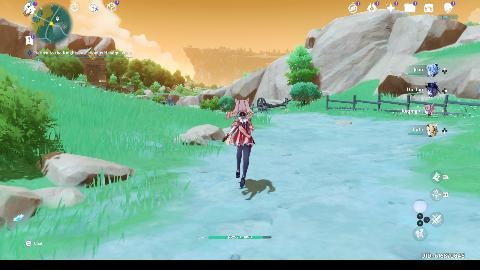

In [36]:
showarray(test_1)

In [37]:
#export to csv
combined_csv_x.to_pickle("../data_reduced/x_training_data.csv")

In [38]:
x_training_data=pd.read_pickle('../data_reduced/x_training_data.csv')  

In [39]:
test_1=df_to_numpy_image(x_training_data,0)
test_1.shape

(270, 480, 3)

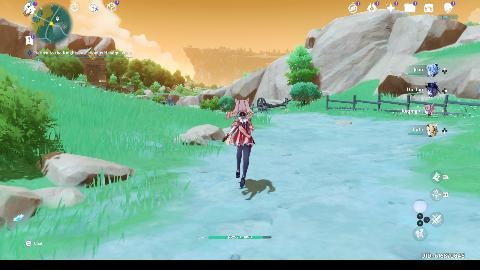

In [40]:
showarray(test_1)

## For inputs

In [41]:
#combine all files in the list
all_filenames_y = [i for i in glob.glob('y_training_data*.{}'.format(extension))]
combined_csv_y = pd.concat([pd.read_csv(f) for f in all_filenames_y])

In [42]:
combined_csv_y.head()

,12,13,11
0,1,1,NaN
1,1,-1,NaN
2,1,-1,NaN
3,1,1,NaN
4,1,1,NaN


In [43]:
combined_csv_y.describe()

,12,13,11
count,1401.000000,1401.000000,162.000000
mean,0.876517,-0.002855,0.037037
std,0.333421,0.714137,0.189438
min,-1.000000,-1.000000,0.000000
25%,1.000000,-1.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [44]:
combined_csv_y['11'].isna().sum()

1239

In [45]:
combined_csv_y['11'] = combined_csv_y['11'].fillna(0)

In [46]:
combined_csv_y['11'].isna().sum()

0

In [47]:
#export to csv
combined_csv_y.to_csv( "../data_reduced/y_training_data.csv", index=False)
#If you getUnicodeEncodeError , simply add encoding='utf-8' ; or encoding='utf-8-sig'

In [48]:
combined_csv_y.shape

(1401, 3)

## Verifing images and inputs

In [49]:
x_training_data=pd.read_pickle('../data_reduced/x_training_data.csv')  
y_training_data=pd.read_csv('../data_reduced/y_training_data.csv')  

In [50]:
x_training_data.shape

(1401, 270)

In [51]:
y_training_data.shape

(1401, 3)

In [52]:
# We count that the size of raws are equal for images and inputs
assert x_training_data.shape[0] == y_training_data.shape[0]

In [53]:
# The size of columns for image is 270
assert x_training_data.shape[1] == 270

In [54]:
test_1=df_to_numpy_image(x_training_data,0)
test_1.shape

(270, 480, 3)

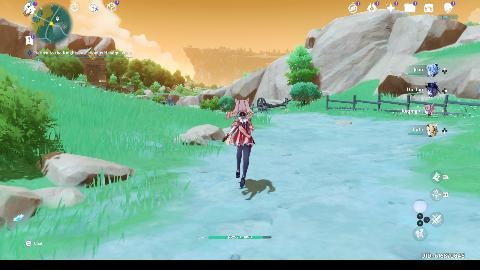

In [55]:
showarray(test_1)

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(x_training_data, y_training_data, test_size=0.2, random_state=6)

Training Samples: 1120
Valid Samples: 281


Text(0.5, 1.0, 'Validation set')

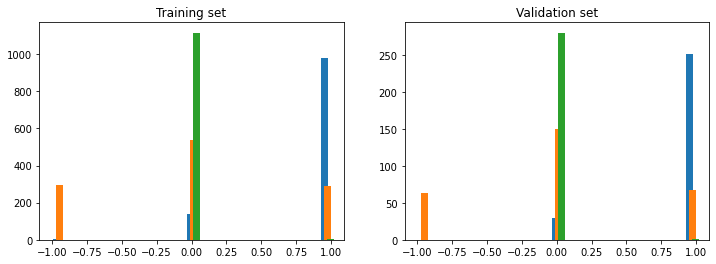

In [57]:
num_bins = 25
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(y_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05)
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05)
axes[1].set_title('Validation set')


The previous plot show the distribution of data to be used. It is seen thant still we have the problem of the unbalanced data, so we require additional procedures to deal this unbalanced data.

In [58]:
import pandas as pd

In [59]:
y_training_data=pd.read_csv('../data_reduced/y_training_data.csv')  

In [60]:
data_y=y_training_data

In [61]:
data_y.head()

,12,13,11
0,1,1,0.0
1,1,-1,0.0
2,1,-1,0.0
3,1,1,0.0
4,1,1,0.0


In [62]:
data_y.describe()

,12,13,11
count,1401.000000,1401.000000,1401.000000
mean,0.876517,-0.002855,0.004283
std,0.333421,0.714137,0.065325
min,-1.000000,-1.000000,0.000000
25%,1.000000,-1.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [63]:
import seaborn as sns
def undersampling(data_y, column_name):
    '''
    data_y : pands dataframe to apply undersampling 
    column_name : column name string
    
    '''
    fig, ax =plt.subplots(1,2)
    #Before undersampling
    sns.countplot(data_y[column_name], ax=ax[0])
    # class count
    class_count_0, class_count_1, class_count_2 = data_y[column_name].value_counts()
    
    # Separate class
    class_0 = data_y[data_y[column_name] == 0]
    class_1 = data_y[data_y[column_name] == 1]
    class_2 = data_y[data_y[column_name] == -1]
    
    
    
    print('class 0:', class_0.shape)
    print('class 1:', class_1.shape)
    print('class 2:', class_2.shape)
    class_0_under = class_0.sample(class_count_1)
    y_under = pd.concat([class_0_under, class_1, class_2], axis=0)
    print("total class of 1 and 0:",y_under[column_name].value_counts())
    # plot the count after under-sampeling
    sns.countplot(y_under[column_name], ax=ax[1])
    fig.show()
    return y_under 

class 0: (687, 3)
class 1: (355, 3)
class 2: (359, 3)
total class of 1 and 0: -1    359
 0    359
 1    355
Name: 13, dtype: int64


C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda3\envs\pygta5\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


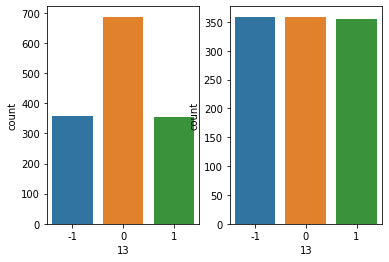

In [64]:
data_y_und=undersampling(data_y,'13')

In [65]:
#pip install seaborn

In [66]:
import seaborn as sns

C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='12', ylabel='count'>

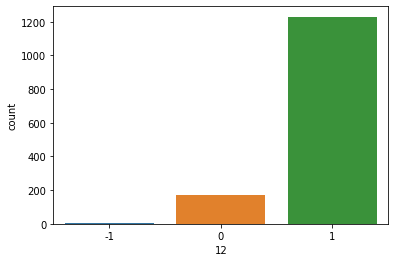

In [67]:
sns.countplot(data_y['12'])

C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='13', ylabel='count'>

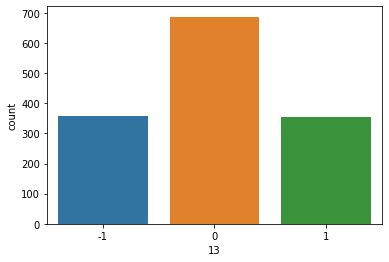

In [68]:
sns.countplot(data_y['13'])

The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfishing.
In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

In [69]:
# class count
class_count_0, class_count_1, class_count_2 = data_y['13'].value_counts()

In [70]:
class_count_0

687

In [71]:
class_count_1

359

In [72]:
class_count_2

355

In [73]:
# Separate class
class_0 = data_y[data_y['13'] == 0]
class_1 = data_y[data_y['13'] == 1]
class_2 = data_y[data_y['13'] == -1]
# print the shape of the class

In [74]:
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
print('class 2:', class_2.shape)

class 0: (687, 3)
class 1: (355, 3)
class 2: (359, 3)


Undersampling can be defined as removing some observations of the majority class. This is done until the majority and minority class is balanced out.

Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback to undersampling is that we are removing information that may be valuable.

In [75]:
class_0_under = class_0.sample(class_count_1)

In [76]:
y_under = pd.concat([class_0_under, class_1, class_2], axis=0)

In [77]:
print("total class of 1 and 0:",y_under['13'].value_counts())
# plot the count after under-sampeling

total class of 1 and 0: -1    359
 0    359
 1    355
Name: 13, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

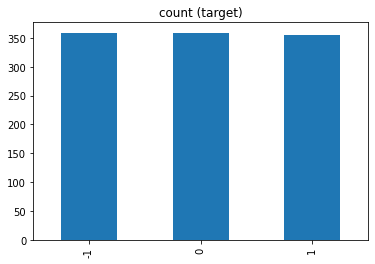

In [78]:
y_under['13'].value_counts().plot(kind='bar', title='count (target)')

In [79]:
type(y_under)

pandas.core.frame.DataFrame

In [80]:
y_under

,12,13,11
28,1,0,0.0
1085,1,0,0.0
984,1,0,0.0
808,1,0,0.0
266,1,0,0.0
...,...,...,...
1384,1,-1,0.0
1393,1,-1,0.0
1398,1,-1,0.0
1399,1,-1,0.0


In [81]:
y_under['13'].value_counts()

-1    359
 0    359
 1    355
Name: 13, dtype: int64

C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='13', ylabel='count'>

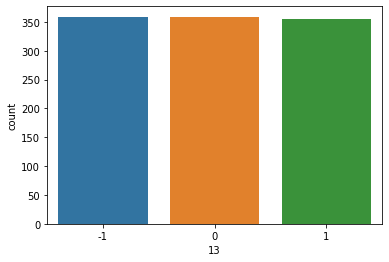

In [82]:
sns.countplot(y_under['13'])

In [83]:
y_under.head()

,12,13,11
28,1,0,0.0
1085,1,0,0.0
984,1,0,0.0
808,1,0,0.0
266,1,0,0.0


class 0: (687, 3)
class 1: (355, 3)
class 2: (359, 3)
total class of 1 and 0: -1    359
 0    359
 1    355
Name: 13, dtype: int64


C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda3\envs\pygta5\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


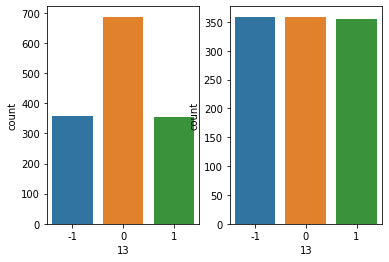

In [84]:
y_under=undersampling(data_y,'13')

In [85]:
y_under.describe()

,12,13,11
count,1073.000000,1073.000000,1073.000000
mean,0.845294,-0.003728,0.005592
std,0.366914,0.816107,0.074604
min,-1.000000,-1.000000,0.000000
25%,1.000000,-1.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


<AxesSubplot:title={'center':'count (target)'}>

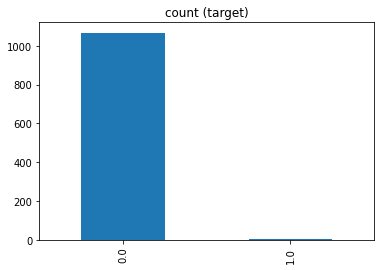

In [86]:
y_under['11'].value_counts().plot(kind='bar', title='count (target)')

In [87]:
del y_under['11']

In [88]:
y_under.describe()

,12,13
count,1073.000000,1073.000000
mean,0.845294,-0.003728
std,0.366914,0.816107
min,-1.000000,-1.000000
25%,1.000000,-1.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


<AxesSubplot:title={'center':'count (target)'}>

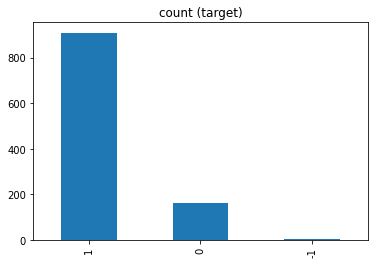

In [89]:
y_under['12'].value_counts().plot(kind='bar', title='count (target)')

In [90]:
def undersampling12(data_y, column_name):
    '''
    data_y : pands dataframe to apply undersampling 
    column_name : column name string
    
    '''
    fig, ax =plt.subplots(1,2)
    #Before undersampling
    sns.countplot(data_y[column_name], ax=ax[0])
    # class count
    class_count_0, class_count_1, class_count_2 = data_y[column_name].value_counts()
    
    # Separate class
    class_0 = data_y[data_y[column_name] == 0]
    class_1 = data_y[data_y[column_name] == 1]
    class_2 = data_y[data_y[column_name] == -1]
    
    print('class 0:', class_0.shape)
    print('class 1:', class_1.shape)
    print('class 2:', class_2.shape)
    class_1_under = class_1.sample(class_count_1)
    y_under = pd.concat([class_0, class_1_under, class_2], axis=0)
    print("total class of 1 and 0:",y_under[column_name].value_counts())
    # plot the count after under-sampeling
    sns.countplot(y_under[column_name], ax=ax[1])
    fig.show()
    return y_under 

class 0: (162, 2)
class 1: (909, 2)
class 2: (2, 2)
total class of 1 and 0:  1    162
 0    162
-1      2
Name: 12, dtype: int64


C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda3\envs\pygta5\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


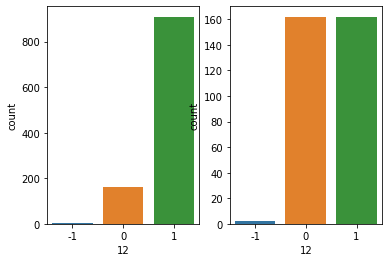

In [91]:
y_under_b=undersampling12(y_under,'12')

C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='13', ylabel='count'>

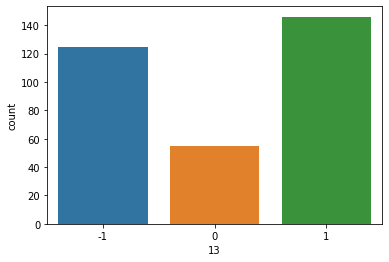

In [92]:
sns.countplot(y_under_b['13'])

C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='12', ylabel='count'>

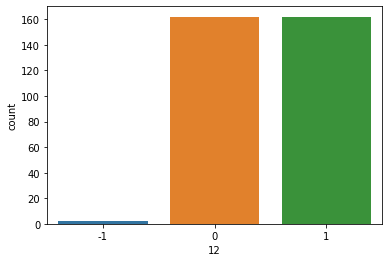

In [93]:
sns.countplot(y_under_b['12'])

In [94]:
#y_under_c=undersampling(y_under_b,'13')

In [95]:
y_under=y_under_b

Selecting Pandas rows based on list index

In [96]:
data_x=pd.read_pickle('../data_reduced/x_training_data.csv')  

In [135]:
y_under.head()

,12,13
315,0,0
316,0,0
324,0,0
246,0,1
247,0,1


In [137]:
y_under.shape

(326, 2)

In [98]:
ind_list =list(y_under.index)

In [99]:
x_under=data_x.iloc[ind_list]

In [100]:
#export to csv
x_under.to_pickle("../data_reduced/undersampling/x_training_data.csv")

In [152]:
y_under.head()

,12,13
315,0,0
316,0,0
324,0,0
246,0,1
247,0,1


In [171]:
#export to csv
y_under.to_csv( "../data_reduced/undersampling/y_training_data.csv", index=True)

In [172]:
y_training_data=pd.read_csv('../data_reduced/undersampling/y_training_data.csv', index_col=[0])  

In [173]:
y_training_data.head()

,12,13
315,0,0
316,0,0
324,0,0
246,0,1
247,0,1


In [174]:
import pandas as pd

## Verifing images and inputs in undersampling

In [250]:
x_training_data=pd.read_pickle('../data_reduced/undersampling/x_training_data.csv')  
y_training_data=pd.read_csv('../data_reduced/undersampling/y_training_data.csv', index_col=[0])  

# Saving small set

In [186]:
divi=(x_training_data.shape[0]-x_training_data.shape[0]%250)/250

In [187]:
total=x_training_data.shape[0]-x_training_data.shape[0]%250

In [188]:
split=total/divi

In [115]:
import pickle

In [190]:
for i in range(int(divi)):
        #processed image rgb color - no image filters
        step_i=i*250
        step_f=step_i+250
        file_name = '../data_reduced/undersampling/chunks/dfx-{}.pkl'.format(i)
        dfx = x_training_data.iloc[step_i:step_f]
        with open(file_name, 'wb') as f:
            pickle.dump(dfx, f)
        print(file_name,step_i,step_f)

../data_reduced/undersampling/chunks/dfx-0.pkl 0 250


In [191]:
for i in range(int(divi)):
        #processed image rgb color - no image filters
        step_i=i*250
        step_f=step_i+250
        file_name = '../data_reduced/undersampling/chunks/dfy-{}.pkl'.format(i)
        dfy = y_training_data.iloc[step_i:step_f]
        with open(file_name, 'wb') as f:
            pickle.dump(dfy, f)
        print(file_name,step_i,step_f)

../data_reduced/undersampling/chunks/dfy-0.pkl 0 250


## Verification of data

In [192]:
x_training_data.shape
# (1401, 270) normal
# (1073, 270) undersampling

(326, 270)

In [193]:
y_training_data.shape
#(1401, 29) normal
#(1073, 29) undersampling

(326, 2)

In [194]:
# We count that the size of raws are equal for images and inputs
assert x_training_data.shape[0] == y_training_data.shape[0]

In [195]:
# The size of columns for image is 270
assert x_training_data.shape[1] == 270

In [196]:
# The size of columns for inputs is 29
#assert y_training_data.shape[1] == 29

In [197]:
#from cleaningdata import *

In [198]:
x_training_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,267,268,269
315,"[[190, 143, 72], [190, 143, 72], [190, 144, 73...","[[184, 136, 68], [182, 134, 67], [183, 134, 67...","[[152, 104, 57], [150, 103, 56], [150, 104, 57...","[[146, 100, 54], [150, 103, 55], [148, 101, 54...","[[145, 98, 51], [146, 100, 53], [146, 100, 53]...","[[143, 97, 50], [142, 97, 51], [144, 100, 53],...","[[135, 97, 50], [138, 95, 49], [140, 98, 51], ...","[[91, 115, 36], [133, 111, 45], [137, 111, 48]...","[[77, 114, 31], [76, 113, 31], [80, 117, 32], ...","[[77, 125, 34], [76, 119, 33], [80, 121, 33], ...",...,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."


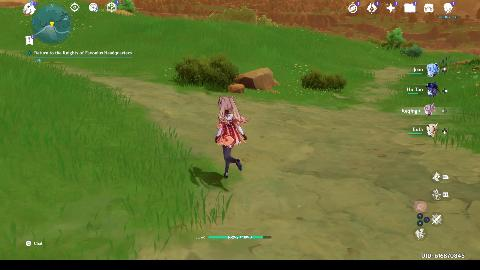

In [204]:
image1=df_to_numpy_image(x_training_data,315)
showarray(image1)

In [ ]:
#os.chdir("../../")

# Creation of the classes directory

In [1]:
import os

In [2]:
path = os.getcwd()

In [3]:
# Parent Directory path
parent_dir = os.path.join(path , 'clean_reduced')

In [4]:
parent_dir

'C:\\Users\\rusla\\Dropbox\\23-GITHUB\\Projects\\BOT-MMORPG-WITH-AI\\versions\\0.01\\clean_reduced'

In [5]:
# Path
path = os.path.join(parent_dir, 'classes')

In [6]:
# Create the directory
os.mkdir(path)
print("Directory '% s' created" % 'classes')

Directory 'classes' created


# Saving classes into different folders

In [7]:
import pandas as pd

In [8]:
x_training_data=pd.read_pickle('./data_reduced/undersampling/x_training_data.csv')  
y_training_data=pd.read_csv('./data_reduced/undersampling/y_training_data.csv', index_col=[0])  

In [9]:
directory1='rx_right'
directory2='rx_zero'
directory3='rx_left'



directory4='ly_up'
directory5='ly_zero'
directory6='ly_down'



In [10]:
# Paths
path1 = os.path.join(path, directory1)
path2 = os.path.join(path, directory2)
path3 = os.path.join(path, directory3)


# Paths
path4 = os.path.join(path, directory4)
path5 = os.path.join(path, directory5)
path6 = os.path.join(path, directory6)


In [11]:
# Create the directory
os.mkdir(path1)
print("Directory '% s' created" % directory1)
os.mkdir(path2)
print("Directory '% s' created" % directory2)
os.mkdir(path3)
print("Directory '% s' created" % directory3)




# Create the directory
os.mkdir(path4)
print("Directory '% s' created" % directory4)
os.mkdir(path5)
print("Directory '% s' created" % directory5)
os.mkdir(path6)
print("Directory '% s' created" % directory6)



Directory 'rx_right' created
Directory 'rx_zero' created
Directory 'rx_left' created
Directory 'ly_up' created
Directory 'ly_zero' created
Directory 'ly_down' created


In [12]:
x_training_data.shape

(326, 270)

In [13]:
y_training_data.shape

(326, 2)

# Clase 13 - Rx Button

C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='13', ylabel='count'>

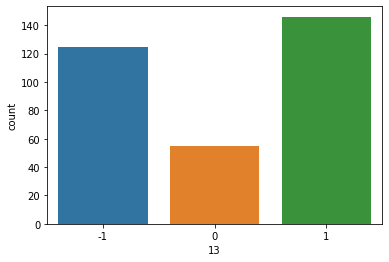

In [14]:
import seaborn as sns
sns.countplot(y_training_data['13'])

In [15]:
rx_right= y_training_data.loc[y_training_data['13'] == 1]
rx_zero= y_training_data.loc[y_training_data['13'] == 0]
rx_left= y_training_data.loc[y_training_data['13'] == -1]

# Clase 12 - Ly Button

C:\Anaconda3\envs\pygta5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='12', ylabel='count'>

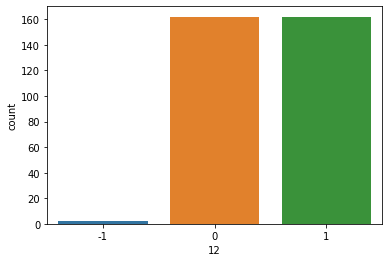

In [16]:
sns.countplot(y_training_data['12'])

In [17]:
ly_up= y_training_data.loc[y_training_data['12'] == 1]
ly_zero= y_training_data.loc[y_training_data['12'] == 0]
ly_down= y_training_data.loc[y_training_data['12'] == -1]

In [18]:
ly_up.index

Int64Index([ 565,  855,  416,  564,  376,  883, 1273,  775,  342,   19,
            ...
             518,  979, 1339,  728,  159,  162,  604, 1207,  168,  772],
           dtype='int64', length=162)

In [24]:
from PIL import Image 

In [25]:
def save_img(x_training_data,clase, index):
    numpy_image=df_to_numpy_image(x_training_data,index)
    PIL_image = Image.fromarray(numpy_image.astype('uint8'), 'RGB')
    PIL_image.save("clase_"+clase+"_"+str(index)+ ".png")

In [26]:
os.chdir(path1)
for index in list(rx_right.index):
    #print(index)
    save_img(x_training_data,"rx_right", index)

In [27]:
os.chdir(path2)
for index in list(rx_zero.index):
    #print(index)
    save_img(x_training_data,"rx_zero", index)

In [28]:
os.chdir(path3)
for index in list(rx_left.index):
    #print(index)
    save_img(x_training_data,"rx_left", index)

In [29]:
os.chdir(path4)
for index in list(ly_up.index):
    #print(index)
    save_img(x_training_data,"ly_up", index)

In [30]:
os.chdir(path5)
for index in list(ly_zero.index):
    #print(index)
    save_img(x_training_data,"ly_zero", index) 

In [31]:
os.chdir(path6)
for index in list(ly_down.index):
    #print(index)
    save_img(x_training_data,"ly_down", index)

In [45]:
os.chdir("../../")

In [43]:
import os
import zipfile
    
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

In [44]:
with zipfile.ZipFile('classes.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir(path, zipf)